# NBA GM Scorer
## *Sports Analytics*
## *Author: Ryan Berns*
---


## **Overview**

In order to calculate GM effectiveness, they will be evaluated on three different fronts: signings, trades and draft.  This will be normalized based on the money spent to ensure GMs who just spend frivalously are not over-valued. Whereas the ones who are more prudent get rewarded for it.<br>
<br>
**I. Data aggregation and pre-processing<br>
II. Join datasets<br>
III. Analysis**
* Signings 
* Trades
* Draft


---
## I. Data Aggregation and Pre-Processing
* Transactions
    * Aggregate transaction data per GM by scraping data from [prosportstransactions.com](prosportstransactions.com)
    * Program identifies how many pages of transactions exist for each executive and then loops through each page scraping the information needed
    * Data will need to be scrubbed and transformed so each row is a player

#### Load List of Active GMs
* GM list was manually created to determine a "starting URL" for each GM included in the analysis

In [3]:
import pandas as pd
gm = pd.read_csv('~/Documents/Fordham/Sports Analytics/nbaGMscorer/activeGMsV2.txt',sep='\t')

In [4]:
gm.head()

,Team,General Manager,Date of hire,Active,URL
0,Atlanta Hawks,Travis Schlenk,2017,Y,http://www.prosportstransactions.com/basketbal...
1,Boston Celtics,Danny Ainge,2003,Y,http://www.prosportstransactions.com/basketbal...
2,Brooklyn Nets,Sean Marks,2016,Y,http://www.prosportstransactions.com/basketbal...
3,Charlotte Hornets,Rich Cho,2011,Y,http://www.prosportstransactions.com/basketbal...
4,Chicago Bulls,Gar Forman,2009,Y,http://www.prosportstransactions.com/basketbal...


#### Plot GMs/Execs by Start Date

Text(0.5,1,'Count of GMs by Hired Date')

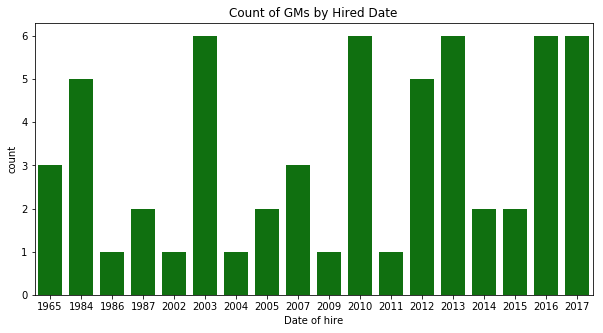

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
gmCnt = sns.countplot(x="Date of hire", data=gm,color='green')
gmCnt.set_title("Count of GMs by Hired Date")

Text(0.5,1,'Count of Active GMs by Hired Date')

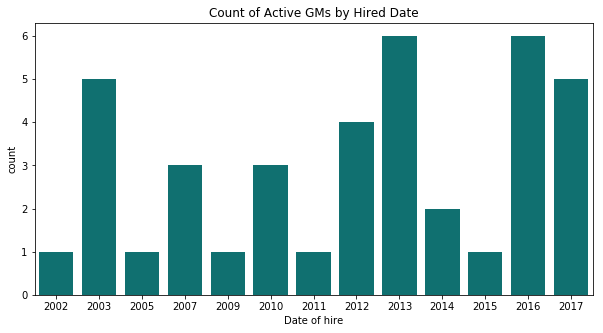

In [6]:
gmNew = gm[(gm["Active"]=="Y")]
plt.figure(figsize=(10,5))
gmCnt = sns.countplot(x="Date of hire", data=gmNew,color='teal')
gmCnt.set_title("Count of Active GMs by Hired Date")

---
#### Scrape Transactions

Transactions for each active GM were scraped in order to determine the transactions for which the GM / executive was responsible for.
* *Note*: the role of the general manager can be very different for each franchise and sometimes the personnel decisions are not solely made by the GM
* Data was sourced from http://www.prosportstransactions.com
* Only contains GMs active as of *March 4th 2018*

**What does the scraper do?**
* Opens up each URL in the csv previously loaded
* Identifies the max number of pages for each "starting page".  For example, Pat Riley has 35 + pages.
* Creates a list of page numbers which apply formatting to URLS into a list
* Program loops through the list and scrapes attributes required:
    * Date
    * Team
    * Acquired
    * Relinquished
    * Notes
* Appends GM name to the transaction data
* Finishes program for GMs listed
* Appends output into a dataframe

In [14]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import urllib.request
import re
import requests
import pprint
class AppURLopener(urllib.request.FancyURLopener):
    version = "Mozilla/5.0"
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [39]:
def gmScrape(gmName,URL):
        query = (URL)
        opener = AppURLopener()
        response = opener.open(query)
        soup = BeautifulSoup(response,'html.parser')
        urlList = []
        for tr in soup.find_all('tr')[-1:]:
            tds = tr.find_all('a')
            for x in tds[:-1]:
                urlList.append(str(URL[:-1])+str(int(x.text)*25)+"&start="+str((int(x.text)*25)-25))
        info = soup.find('table',{'class':'datatable center'})
        date = []
        team = []
        acquired = []
        relinquished = []
        notes = []
        for tr in soup.find_all('tr')[2:-1]:
            tds = tr.find_all('td')
            date.append(tds[0].text)
            team.append(tds[1].text)
            acquired.append(tds[2].text)
            relinquished.append(tds[3].text)
            notes.append(tds[4].text)
        for y in urlList:
            query = (str(y))
            opener = AppURLopener()
            response = opener.open(query)
            soup = BeautifulSoup(response,'html.parser')
            for tr in soup.find_all('tr')[1:-1]:
                tds = tr.find_all('td')
                date.append(tds[0].text)
                team.append(tds[1].text)
                acquired.append(tds[2].text)
                relinquished.append(tds[3].text)
                notes.append(tds[4].text)
        df1 = pd.DataFrame({'date':date,
                     'team': team,
                     'acquired':acquired,
                     'relinquished':relinquished,
                     'notes':notes})
        df1['GM'] = gmName
        return(df1)

In [40]:
finalDat = pd.DataFrame()
for genM,urlEach in zip(gm['General Manager'],gm['URL']):
    if str(urlEach).lower()=="nan":
        pass
    else:
        dat = gmScrape(str(genM),str(urlEach))
        finalDat = pd.concat([finalDat,dat])
        finalDat.reset_index()

In [41]:
# Review data structure
finalDat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13423 entries, 0 to 69
Data columns (total 6 columns):
acquired        13423 non-null object
date            13423 non-null object
notes           13423 non-null object
relinquished    13423 non-null object
team            13423 non-null object
GM              13423 non-null object
dtypes: object(6)
memory usage: 734.1+ KB


In [42]:
# Count records
print("Total transactions scraped: ",len(finalDat))

Total transactions scraped:  13423


In [43]:
finalDat.query('GM=="Pat Riley"').head()

,acquired,date,notes,relinquished,team,GM
0,• Randy Pfund,1995-09-19,hired as executive VP of player personnel,,Heat,Pat Riley
1,• Bob McAdoo,1995-09-20,hired as assistant coach,,Heat,Pat Riley
2,• Jeff Bzdelik,1995-09-20,hired as assistant coach / scout,,Heat,Pat Riley
3,• Scotty Robertson,1995-09-20,hired as assistant coach,,Heat,Pat Riley
4,• Stan Van Gundy,1995-09-20,hired as assistant coach,,Heat,Pat Riley


In [20]:
# Save to a .csv
finalDat.to_csv('scrapedTransactions042218.csv',sep=',')

#### Analyze Transaction Volume by GM
* Count of Transactions by GM
* Count of Volume for the top 5 GMs with most transactions:<br>
    1) Bryan Colangelo<br>
    2) Pat Riley<br>
    3) Ernie Grunfeld<br>
    4) Elgin Baylor<br>
    5) Pete Babcock

** Transaction Count by GM **

Text(0.5,1,'Count of Transaction by GM')

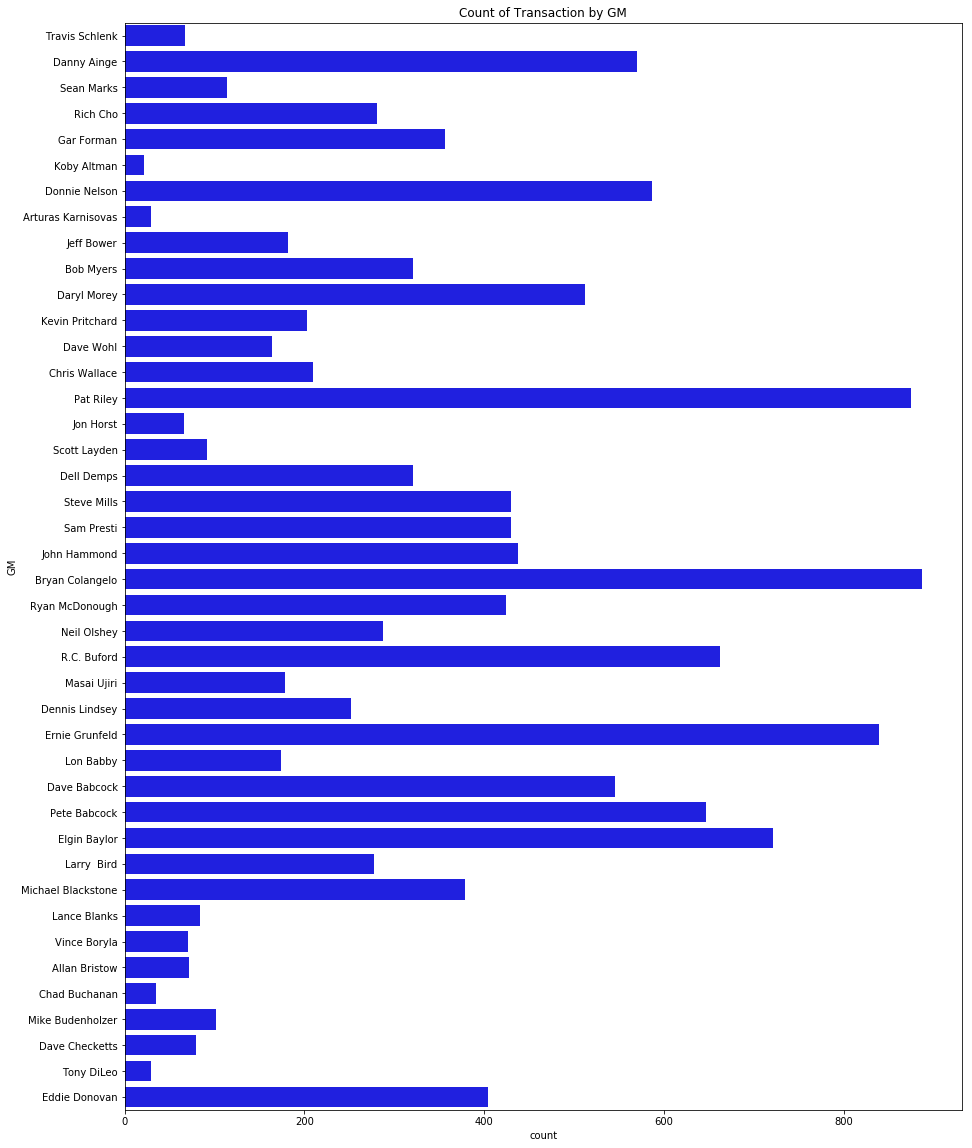

In [21]:
plt.figure(figsize=(15,20))
finalDat.groupby(finalDat['GM']).count()
gmCnt2 = sns.countplot(y='GM', data=finalDat,color='blue')
gmCnt2.set_title("Count of Transaction by GM")

**Top 5 GMs**

Text(0.5,1,'Count of Transaction by Executive')

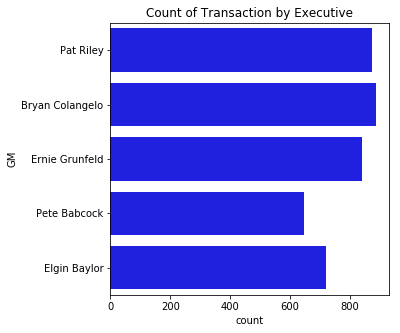

In [22]:
plt.figure(figsize=(5,5))
# newFin = finalDat.groupby(finalDat['GM']).count().sort_values("team",ascending=False).reset_index().head()

topGmsTransactions = ("Bryan Colangelo","Pat Riley","Ernie Grunfeld","Elgin Baylor", "Pete Babcock")
newFin = finalDat[(finalDat["GM"].isin(topGmsTransactions))]
gmCnt2 = sns.countplot(y='GM', data=newFin,color='blue')
gmCnt2.set_title("Count of Transaction by Executive")

#### Clean Transaction Data for Analysis
* Remove special characters from acquired column
* Remove special characters from relinquished column
* Normalize the transactions so that each row is a player

**Sample of Data**

In [44]:
finalDat.head()

,acquired,date,notes,relinquished,team,GM
0,• Marco Belinelli• Miles Plumlee• 2017 second...,2017-06-20,trade with Hornets,• Dwight Howard• 2017 second round pick (#31-...,Hawks,Travis Schlenk
1,• Alpha Kaba,2017-06-22,2017 NBA draft second round pick (#60 overall),,Hawks,Travis Schlenk
2,• John Collins (b),2017-06-22,2017 NBA draft first round pick (#19 overall),,Hawks,Travis Schlenk
3,• Tyler Dorsey,2017-06-22,2017 NBA draft second round pick (#41 overall),,Hawks,Travis Schlenk
4,• Tim Hardaway Jr.,2017-06-26,"team tendered $4.6M qualifying offer, making ...",,Hawks,Travis Schlenk


**Remove special characters from columns**

In [45]:
newDat = finalDat
newDat['acquired'] = newDat['acquired'].astype('str').str.replace('•','|').str.strip().map(lambda x: x.split('|')[1:])
newDat['relinquished'] = newDat['relinquished'].astype('str').str.replace('•','|').str.strip().map(lambda x: x.split('|')[1:])
newDat.head(3)

,acquired,date,notes,relinquished,team,GM
0,"[ Marco Belinelli, Miles Plumlee, 2017 secon...",2017-06-20,trade with Hornets,"[ Dwight Howard, 2017 second round pick (#31-...",Hawks,Travis Schlenk
1,[ Alpha Kaba],2017-06-22,2017 NBA draft second round pick (#60 overall),[],Hawks,Travis Schlenk
2,[ John Collins (b)],2017-06-22,2017 NBA draft first round pick (#19 overall),[],Hawks,Travis Schlenk


**Classify transaction types and build flags**
* If notes contains the term "pick" then it will be classified as drafted
* If notes contains the term "trade" then it will be classfied as traded
* If the acquired column has more than 1 item and relinquished does not contain anything and it does not contain draft pick then it will be classified as "signing"
* Opposite criteria is used for released
* For draft picks, the actual pick number is extracted from the notes

In [46]:
newDat['drafted'] = newDat['notes'].map(lambda x: x.lower()).str.contains('pick')
newDat['traded'] = newDat['notes'].map(lambda x: x.lower()).str.contains('trade')
newDat['signed'] = (newDat['acquired'].map(lambda x: len(x)) >= 1) & (newDat['relinquished'].map(lambda x: len(x)) == 0) & (newDat['notes'].map(lambda x: x.lower()).str.contains('pick')==False)
newDat['released'] = (newDat['acquired'].map(lambda x: len(x)) == 0) & (newDat['relinquished'].map(lambda x: len(x)) >= 1)
newDat['DraftPickNo'] = newDat['notes'].map(lambda x: x.lower()).str.extract('#(.\d)',expand=False)                                                                    

**Ensure dataset has one of the flags created set to true**

In [47]:
newDatClassified = newDat[(newDat['signed']==True) | (newDat['traded']==True) | (newDat['released']==True) | (newDat['drafted']==True)] 

In [48]:
print("Resulting record count: ", len(newDatClassified))

Resulting record count:  13318


*Note: Data also includes transactions for personnel (i.e. coaches, scouts and other execs which will be ignored for this analysis)*

In [49]:
newDatClassified.head(3).T

,0,1,2
acquired,"[ Marco Belinelli, Miles Plumlee, 2017 secon...",[ Alpha Kaba],[ John Collins (b)]
date,2017-06-20,2017-06-22,2017-06-22
notes,trade with Hornets,2017 NBA draft second round pick (#60 overall),2017 NBA draft first round pick (#19 overall)
relinquished,"[ Dwight Howard, 2017 second round pick (#31-...",[],[]
team,Hawks,Hawks,Hawks
GM,Travis Schlenk,Travis Schlenk,Travis Schlenk
drafted,False,True,True
traded,True,False,False
signed,False,False,False
released,False,False,False


#### Transpose acquired field to create a table that explodes out the dataset so each player has its own record

In [50]:
newDatClassified = newDatClassified.reset_index()
final = newDatClassified.join(newDatClassified.acquired.apply(pd.Series)
                          .stack()
                          .reset_index(level=1, drop=True)
                          .to_frame('acquired'),rsuffix='keep_')

In [52]:
final.head(5)

,index,acquired,date,notes,relinquished,team,GM,drafted,traded,signed,released,DraftPickNo,acquiredkeep_
0,0,"[ Marco Belinelli, Miles Plumlee, 2017 secon...",2017-06-20,trade with Hornets,"[ Dwight Howard, 2017 second round pick (#31-...",Hawks,Travis Schlenk,False,True,False,False,NaN,Marco Belinelli
0,0,"[ Marco Belinelli, Miles Plumlee, 2017 secon...",2017-06-20,trade with Hornets,"[ Dwight Howard, 2017 second round pick (#31-...",Hawks,Travis Schlenk,False,True,False,False,NaN,Miles Plumlee
0,0,"[ Marco Belinelli, Miles Plumlee, 2017 secon...",2017-06-20,trade with Hornets,"[ Dwight Howard, 2017 second round pick (#31-...",Hawks,Travis Schlenk,False,True,False,False,NaN,2017 second round pick (#41-Tyler Dorsey)
1,1,[ Alpha Kaba],2017-06-22,2017 NBA draft second round pick (#60 overall),[],Hawks,Travis Schlenk,True,False,False,False,60,Alpha Kaba
2,2,[ John Collins (b)],2017-06-22,2017 NBA draft first round pick (#19 overall),[],Hawks,Travis Schlenk,True,False,False,False,19,John Collins (b)


#### Develop summary statistics for transaction volume based on transaction type

In [54]:
final['transaction count'] =1       #initially, set that counter to 1.
group_data = final.groupby(['GM','drafted','traded','signed','released'])['transaction count'].sum() 
group_data.head()

GM                  drafted  traded  signed  released
Allan Bristow       False    False   False   True        25
                                     True    False       30
                             True    False   False       14
                    True     False   False   False        8
Arturas Karnisovas  False    False   False   True         5
Name: transaction count, dtype: int64

In [55]:
import numpy as np
finalTmp = final.groupby(['GM','drafted','traded','signed','released'], as_index=False).sum()
# finalTmp.head()
# Drafted
finalTmp['drafted'] = np.where(finalTmp['drafted'] == True, finalTmp['transaction count'], finalTmp['drafted'])
finalTmp['drafted'] = np.where(finalTmp['drafted'] == False, 0, finalTmp['drafted'])

# Traded
finalTmp['signed'] = np.where(finalTmp['signed'] == True, finalTmp['transaction count'], finalTmp['signed'])
finalTmp['signed'] = np.where(finalTmp['signed'] == False, 0, finalTmp['signed'])

# Signed
finalTmp['traded'] = np.where(finalTmp['traded'] == True, finalTmp['transaction count'], finalTmp['traded'])
finalTmp['traded'] = np.where(finalTmp['traded'] == False, 0, finalTmp['traded'])

# Released
finalTmp['released'] = np.where(finalTmp['released'] == True, finalTmp['transaction count'], finalTmp['released'])
finalTmp['released'] = np.where(finalTmp['released'] == False, 0, finalTmp['released'])
# finalTmp.head()


finalTmp2 = pd.melt(finalTmp, id_vars=['GM'], value_vars=['drafted','traded','signed','released'],var_name='type', value_name='cnt')
finalTmp2.drop_duplicates(inplace=True)
# finalTmp2.head()

finalTmp3 = finalTmp2[(finalTmp2['cnt']>0)]
finalTmp3.head()

,GM,type,cnt
3,Allan Bristow,drafted,8
7,Arturas Karnisovas,drafted,5
11,Bob Myers,drafted,17
15,Bryan Colangelo,drafted,70
19,Chad Buchanan,drafted,3


Text(0.5,1,'Transaction Volume by Type')

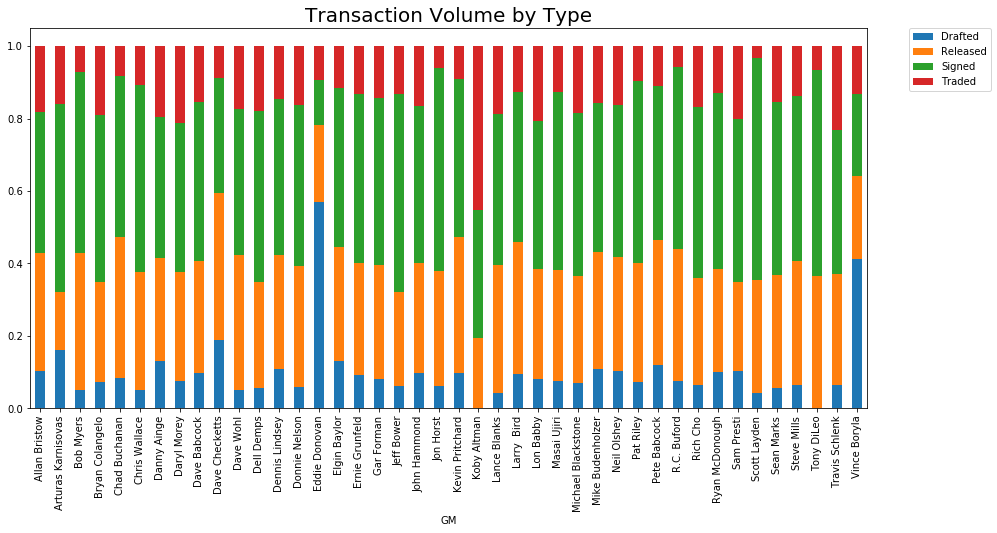

In [56]:
from matplotlib.pyplot import *
tps = finalTmp3.pivot_table(values=['cnt'], 
                      index='GM',
                      columns='type',
                      aggfunc='sum')

tps = tps.div(tps.sum(1), axis=0)
tps.plot(kind='bar', stacked=True,figsize=(15,7))
legend(labels = ('Drafted','Released','Signed','Traded'),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Transaction Volume by Type",fontsize = 20)

---
### Import Player Statistics
* **Source**: https://www.kaggle.com/drgilermo/nba-players-stats/data
* Each row is a player and year

In [58]:
baseStats = pd.read_csv('~/Documents/Fordham/Sports Analytics/nbaGMscorer/season_stats.csv',sep=',')

#### Win Shares
* Descriptive statistics
* Histrogram (all seasons after 2010)

> **What is win share?** <br>
Win share is composed of 2 aggregate measures for both offense and defense.
<br>
<br>
*Offensive win shares* are derived from 4 components:
1. Calculate points produced per player
2. Calculate offensive posessions
3. Calculate marginal offense for each player
4. Calculate marginal points per win
5. Credit offensive win shares to the players
<br>
<br>
*Defensive win shares* are derived from 4 components:
1. Calculate defensive rating (estimate of the player's points allowed per 100 defensive posessions
2. Calculate marginal defense for each player (incorporates team defensive measures)
3. Calculate marginal points per win
4. Credit defensive win shares to players
> *Source:* https://www.basketball-reference.com/about/ws.html


** Describe All Columns in Dataset **

In [61]:
pd.options.display.max_columns = 999
baseStats.describe(include='all')

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,24691.000000,24624.000000,24624,24624,24616.000000,24624,24624.000000,18233.000000,24138.000000,24101.000000,24538.000000,18839.000000,24525.000000,20792.000000,20792.000000,21571.000000,22555.000000,20792.000000,20792.000000,19582.000000,19640.000000,0.0,24585.000000,24585.000000,24585.000000,24101.000000,0.0,20797.000000,20797.000000,20797.000000,20797.000000,24624.000000,24624.000000,24525.000000,18927.000000,18927.000000,15416.000000,24624.000000,24624.000000,24496.000000,24525.000000,24624.000000,24624.000000,23766.000000,20797.000000,20797.000000,24312.000000,24624.000000,20797.000000,20797.000000,19645.000000,24624.000000,24624.000000
unique,NaN,NaN,3921,23,NaN,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Eddie Johnson,PF,NaN,TOT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,33,4966,NaN,2123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,12345.000000,1992.594989,NaN,NaN,26.664405,NaN,50.837110,23.593375,1209.720317,12.479071,0.493001,0.158604,0.325455,6.181565,13.708657,9.949210,13.009962,1.648269,1.410624,15.085099,18.906492,NaN,1.257307,1.227395,2.485796,0.065002,NaN,-1.778386,-0.548570,-2.326720,0.559879,195.325820,430.645752,0.430817,22.215037,63.604480,0.248796,178.250447,381.756782,0.445343,0.450658,102.389336,136.775219,0.719279,62.189210,147.199404,224.637381,114.852623,39.897052,24.470260,73.939832,116.339222,510.116350
std,7127.822084,17.429594,NaN,NaN,3.841892,NaN,26.496161,28.632387,941.146575,6.039014,0.094469,0.187495,0.218971,4.872685,6.636402,5.040283,9.191843,1.017024,1.773348,6.919170,5.448157,NaN,2.136256,1.269613,3.058638,0.102471,NaN,3.792947,2.253106,4.691619,1.336892,188.114361,397.624715,0.095921,38.543366,102.442769,0.176683,179.478923,371.260335,0.099803,0.099200,113.373565,146.078918,0.141824,67.324881,145.921912,228.190203,135.863913,38.713053,36.935084,67.713803,84.791873,492.922981
min,0.000000,1950.000000,NaN,NaN,18.000000,NaN,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-5.100000,-1.000000,-2.800000,-2.519000,NaN,-73.800000,-30.400000,-86.700000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6172.500000,1981.000000,NaN,NaN,24.000000,NaN,27.000000,0.000000,340.000000,9.800000,0.458000,0.005000,0.208000,2.600000,8.800000,5.900000,6.500000,1.100000,0.300000,11.400000,15.400000,NaN,-0.100000,0.200000,0.200000,0.031000,NaN,-3.400000,-1.700000,-4.200000,-0.200000,41.000000,99.000000,0.393000,0.000000,1.000000,0.100000,35.000000,82.000000,0.407000,0.414000,18.000000,27.000000,0.657000,12.000000,33.000000,51.000000,19.000000,9.000000,3.000000,18.000000,39.000000,106.000000
50%,12345.000000,1996.000000,NaN,NaN,26.000000,NaN,58.000000,8.000000,1053.000000,12.700000,0.506000,0.064000,0.296000,5.400000,12.700000,9.200000,10.500000,1.500000,0.900000,14.200000,18.600000,NaN,0.400000,0.800000,1.400000,0.075000,NaN,-1.500000,-0.500000,-1.800000,0.000000,141.000000,321.000000,0.439000,2.000000,11.000000,0.292000,122.000000,270.000000,0.456000,0.463000,63.000000,88.000000,0.743000,38.000000,106.000000,159.000000,68.000000,29.000000,11.000000,55.000000,109.000000,364

*Potential issues:*
* TOT stats for the season will need to be removed prior to joining
* 2,4691 records included
* 69 teams shown which might cause issues

**Review Win Shares**

In [62]:
baseStats['WS'].describe(include = 'all')

count    24585.000000
mean         2.485796
std          3.058638
min         -2.800000
25%          0.200000
50%          1.400000
75%          3.800000
max         25.400000
Name: WS, dtype: float64

Text(0.5,1,'Histrogram of Win Share (2010 - Current)')

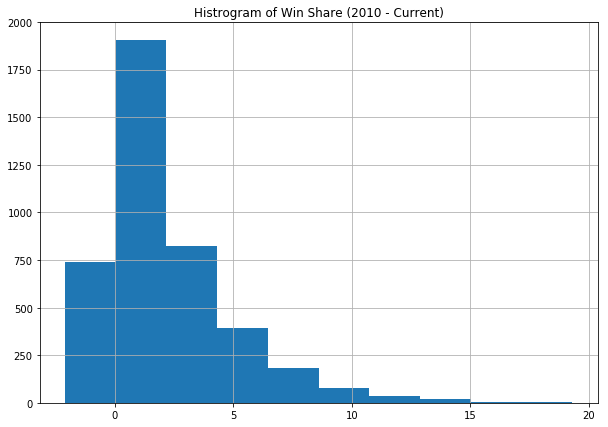

In [63]:
baseStats[(baseStats['Year'] > 2010)]['WS'].hist(figsize=(10,7))
plt.title("Histrogram of Win Share (2010 - Current)")

** Histograms can be used to view the distribution of key numeric features**

C:\Anaconda2\envs\py36\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Anaconda2\envs\py36\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Anaconda2\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


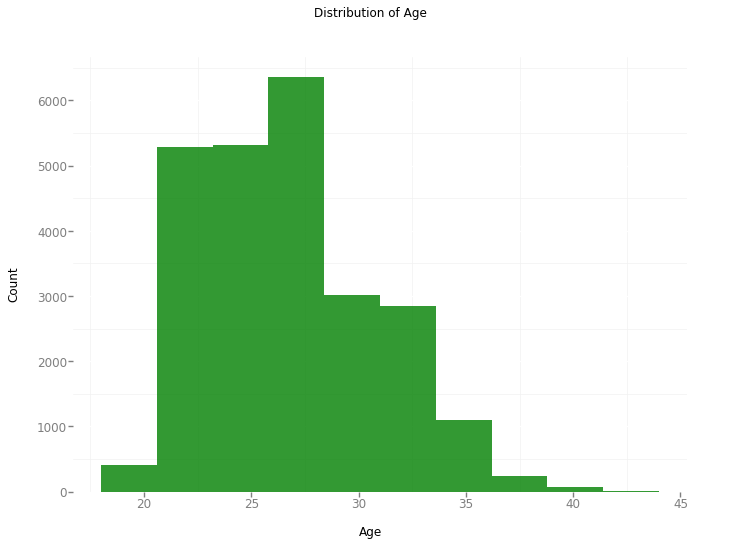

<ggplot: (137695132273)>

In [64]:
from ggplot import ggplot
from ggplot import *
ggplot(aes(x='Age'), data=baseStats) + \
        geom_histogram(alpha = 0.8,fill = 'green') +\
        ylab("Count") +\
        ggtitle('Distribution of Age') +\
        theme_bw()

---
#### Salary Data
Salary data was imported from [https://data.world/datadavis/nba-salaries](https://data.world/datadavis/nba-salaries)

In [65]:
salary = pd.read_csv('salaries.csv',sep=',')
salary.head()

,player,salary,season_end,season_start,team,team_name
0,Moses Malone,2406000,1991,1990,ATL,Atlanta Hawks
1,Dominique Wilkins,2065000,1991,1990,ATL,Atlanta Hawks
2,Jon Koncak,1550000,1991,1990,ATL,Atlanta Hawks
3,Doc Rivers,895000,1991,1990,ATL,Atlanta Hawks
4,Rumeal Robinson,800000,1991,1990,ATL,Atlanta Hawks


**Descriptive Statistics**
* Average Salary by Season
* Histogram of $M per Win Share (requires joining to salaries to statistics)

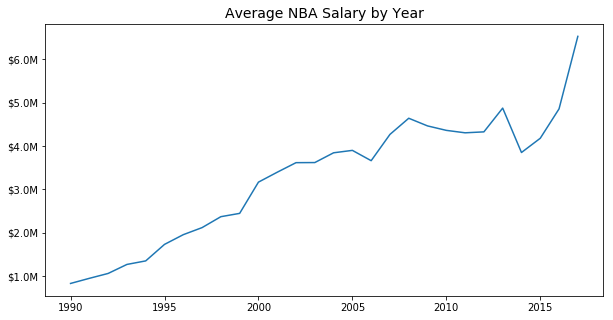

In [66]:
salaryGroup = salary.groupby(salary['season_start'],as_index=False).mean()

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)
formatter = FuncFormatter(millions)
fig, ax = plt.subplots(figsize=(10,5))
ax.yaxis.set_major_formatter(formatter)
plt.plot(salaryGroup['season_start'],salaryGroup['salary'])
plt.title("Average NBA Salary by Year",fontsize=14)
plt.show()
plt.figure(figsize=(10,10))


***
## Merge Data
* Filter stats data to be 2005 and onward
* Remove TOT stats
* Make player names on lower case
* Convert the year column to an int data type for joining purposes
* Join data together

**Filter stats to be 2005 and onwards.  Also remove TOT stats.**

In [89]:
newStats = baseStats[(baseStats['Year']>=2005) & (baseStats['Tm']!= "TOT")]

In [90]:
print("New Count for Stats Data: ", len(newStats))

New Count for Stats Data:  6852


In [91]:
pd.options.mode.chained_assignment = None  # default='warn'
newStats['Player'] = newStats['Player'].map(lambda x: x.lower())

In [92]:
newStats = newStats.drop(columns=['Unnamed: 0','blanl','blank2',])

In [93]:
newStats.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
17076,2005.0,shareef abdur-rahim,PF,28.0,POR,54.0,49.0,1867.0,18.7,0.581,0.058,0.379,7.9,16.0,12.1,10.7,1.4,1.0,13.0,22.1,3.9,1.5,5.4,0.139,1.4,-0.5,0.8,1.3,337.0,670.0,0.503,15.0,39.0,0.385,322.0,631.0,0.510,0.514,220.0,254.0,0.866,123.0,269.0,392.0,111.0,49.0,26.0,117.0,150.0,909.0
17077,2005.0,cory alexander,SG,31.0,CHA,16.0,1.0,201.0,8.8,0.451,0.388,0.245,4.3,12.6,8.2,27.7,2.3,0.4,25.9,16.2,-0.2,0.2,0.0,0.002,-2.9,-0.5,-3.4,-0.1,16.0,49.0,0.327,8.0,19.0,0.421,8.0,30.0,0.267,0.408,9.0,12.0,0.750,8.0,21.0,29.0,37.0,9.0,1.0,19.0,29.0,49.0
17079,2005.0,malik allen,PF,26.0,MIA,14.0,0.0,248.0,13.6,0.505,0.000,0.184,11.8,12.7,12.2,7.0,0.9,3.3,11.8,17.5,0.3,0.3,0.6,0.113,-1.7,0.6,-1.1,0.1,35.0,76.0,0.461,0.0,0.0,NaN,35.0,76.0,0.461,0.461,13.0,14.0,0.929,24.0,28.0,52.0,11.0,4.0,11.0,11.0,29.0,83.0
17080,2005.0,malik allen,PF,26.0,CHA,22.0,1.0,271.0,14.8,0.518,0.000,0.139,6.4,13.8,9.9,4.6,1.0,3.1,6.1,18.7,0.3,0.2,0.5,0.088,-2.4,-1.0,-3.4,-0.1,49.0,101.0,0.485,0.0,0.0,NaN,49.0,101.0,0.485,0.485,13.0,14.0,0.929,16.0,31.0,47.0,7.0,5.0,11.0,7.0,24.0,111.0
17081,2005.0,ray allen,SG,29.0,SEA,78.0,78.0,3064.0,20.9,0.555,0.372,0.286,3.2,10.7,6.9,18.1,1.5,0.1,9.2,28.0,9.7,1.0,10.7,0.168,5.6,-1.9,3.7,4.4,640.0,1494.0,0.428,209.0,556.0,0.376,431.0,938.0,0.459,0.498,378.0,428.0,0.883,79.0,268.0,347.0,289.0,84.0,5.0,171.0,167.0,1867.0


In [94]:
newStats['Year'] = newStats['Year'].map(lambda x: int(x))
newStats2 = newStats.set_index(['Player','Year','Tm']).reset_index()

In [95]:
salary['player'] = salary['player'].map(lambda x: x.lower())
salary['season_start'] = salary['season_start'].map(lambda x: round(int(x),1))

In [96]:
updatedNew = pd.merge(newStats2,salary,left_on=['Player','Year','Tm'], right_on=['player','season_start','team'])

In [97]:
print(len(newStats2))
print(len(updatedNew))

6852
2825


*Issue: There were major issues with the join resulting in many records not joining*

**Improvements to Fix Join Logic**
* Total stats were removed from the stats file
* Mapping table manually created in order to provide consistency for team abbrevations is used
* There were several teams without transactions as actie GMs were not pulled for them or data was unavailable in the source data
    - Chicago Bulls
    - Charlotte Hornets
    - Los Angeles Lakers
    - Oklahoma City Thunder
    - Orlando Magic
    - Sacramento Kings

In [98]:
teamLu = pd.read_csv('teamName.csv',sep=',')
teamLu.columns = ['tm_stats','tm_salary','tm_transactions']
teamLu.head()

,tm_stats,tm_salary,tm_transactions
0,ATL,ATL,Hawks
1,BOS,BOS,Celtics
2,BRK,NJN,Nets
3,CHA,CHA,Bobcats
4,CHI,CHI,NaN


In [100]:
newStatsTeam = pd.merge(newStats2,teamLu,left_on=['Tm'], right_on=['tm_stats'])

In [101]:
newStatsTeam.head()

,Player,Year,Tm,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,tm_stats,tm_salary,tm_transactions
0,shareef abdur-rahim,2005,POR,PF,28.0,54.0,49.0,1867.0,18.7,0.581,0.058,0.379,7.9,16.0,12.1,10.7,1.4,1.0,13.0,22.1,3.9,1.5,5.4,0.139,1.4,-0.5,0.8,1.3,337.0,670.0,0.503,15.0,39.0,0.385,322.0,631.0,0.510,0.514,220.0,254.0,0.866,123.0,269.0,392.0,111.0,49.0,26.0,117.0,150.0,909.0,POR,POR,Blazers
1,derek anderson,2005,POR,SG,30.0,47.0,32.0,1239.0,11.7,0.503,0.386,0.223,2.4,9.2,6.0,18.9,1.6,0.2,14.0,18.5,0.7,0.6,1.3,0.052,-0.3,-1.8,-2.1,0.0,152.0,391.0,0.389,58.0,151.0,0.384,94.0,240.0,0.392,0.463,70.0,87.0,0.805,25.0,103.0,128.0,143.0,36.0,4.0,70.0,89.0,432.0,POR,POR,Blazers
2,maurice baker,2005,POR,PG,25.0,4.0,0.0,18.0,-0.2,0.000,0.000,0.000,6.7,6.2,6.4,7.6,3.0,0.0,50.0,5.1,0.0,0.0,0.0,-0.059,-7.1,2.2,-4.9,0.0,0.0,1.0,0.000,0.0,0.0,NaN,0.0,1.0,0.000,0.000,0.0,0.0,NaN,1.0,1.0,2.0,1.0,1.0,0.0,1.0,3.0,0.0,POR,POR,Blazers
3,geno carlisle,2005,POR,SG,28.0,6.0,0.0,16.0,18.1,0.709,0.000,2.000,7.5,0.0,3.6,10.3,0.0,0.0,15.1,19.1,0.1,0.0,0.1,0.173,1.3,-5.5,-4.2,0.0,2.0,3.0,0.667,0.0,0.0,NaN,2.0,3.0,0.667,0.667,4.0,6.0,0.667,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,8.0,POR,POR,Blazers
4,richie frahm,2005,POR,SG,27.0,43.0,0.0,499.0,12.4,0.543,0.571,0.179,4.1,9.8,7.1,9.7,1.6,0.6,8.5,15.2,0.7,0.3,1.0,0.097,0.5,-2.0,-1.5,0.1,56.0,140.0,0.400,31.0,80.0,0.388,25.0,60.0,0.417,0.511,21.0,25.0,0.840,17.0,44.0,61.0,30.0,15.0,4.0,14.0,35.0,164.0,POR,POR,Blazers


In [217]:
updatedNew2 = pd.merge(newStatsTeam,salary,left_on=['Player','Year','tm_salary'], right_on=['player','season_end','team'],how='inner')
print(len(newStatsTeam))
print(len(updatedNew2))

6852
5179


**Data Errors**
* There is no data for the charlotte bobcats.  Only data available for hornets
* When players get traded, there seems to be a mismatch (consider matching without team name)

**We will move on with the analysis but this will need to be addressed in future iterations**

---
## Create WS per $M using resulting dataset

In [218]:
updatedNew2['WS per $M'] = (updatedNew2['WS']/(updatedNew2['salary']/1000000))

Text(0.5,1,'Histrogram of Win Share per $M')

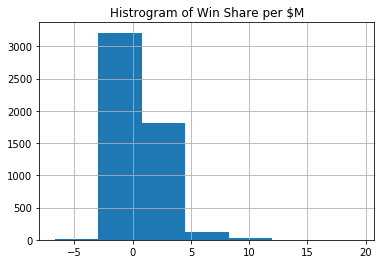

In [220]:
updatedNew2['WS per $M'].hist(bins=7)
plt.title("Histrogram of Win Share per $M")

In [221]:
updatedNew2[(updatedNew2['WS per $M'] > 10)].head()

,Player,Year,Tm,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,tm_stats,tm_salary,tm_transactions,player,salary,season_end,season_start,team,team_name,WS per $M
187,udonis haslem,2005,MIA,PF,24.0,80.0,80.0,2675.0,15.5,0.588,0.006,0.351,10.9,20.4,15.8,6.3,1.2,1.1,13.2,14.9,5.2,4.0,9.2,0.165,0.6,1.3,1.8,2.6,346.0,641.0,0.540,0.0,4.0,0.000,346.0,637.0,0.543,0.540,178.0,225.0,0.791,239.0,487.0,726.0,108.0,63.0,41.0,113.0,260.0,870.0,MIA,MIA,Heat,udonis haslem,620046,2005,2004,MIA,Miami Heat,14.837609
309,hassan whiteside,2016,MIA,C,26.0,73.0,43.0,2125.0,25.7,0.629,0.000,0.482,13.1,32.4,23.1,2.4,1.1,9.7,14.2,20.7,5.0,5.3,10.3,0.233,-0.9,3.4,2.5,2.4,413.0,682.0,0.606,0.0,0.0,NaN,413.0,682.0,0.606,0.606,214.0,329.0,0.650,238.0,627.0,865.0,30.0,44.0,269.0,137.0,201.0,1040.0,MIA,MIA,Heat,hassan whiteside,981348,2016,2015,MIA,Miami Heat,10.495767
522,matt bonner,2005,TOR,C,24.0,82.0,0.0,1553.0,14.7,0.596,0.199,0.153,7.7,13.1,10.4,5.3,1.3,0.9,7.5,15.7,3.3,0.9,4.2,0.130,0.9,-1.1,-0.1,0.7,247.0,463.0,0.533,39.0,92.0,0.424,208.0,371.0,0.561,0.576,56.0,71.0,0.789,108.0,177.0,285.0,48.0,39.0,19.0,40.0,220.0,589.0,TOR,TOR,Raptors,matt bonner,385277,2005,2004,TOR,Toronto Raptors,10.901248
576,jamario moon,2008,TOR,SF,27.0,78.0,75.0,2166.0,15.0,0.540,0.212,0.148,5.0,21.6,13.2,6.2,2.0,4.0,7.7,14.4,2.1,3.6,5.7,0.126,-0.8,3.5,2.8,2.6,279.0,575.0,0.485,40.0,122.0,0.328,239.0,453.0,0.528,0.520,63.0,85.0,0.741,92.0,392.0,484.0,90.0,80.0,108.0,51.0,152.0,661.0,TOR,TOR,Raptors,jamario moon,427163,2008,2007,TOR,Toronto Raptors,13.343852
1283,landry fields,2011,NYK,SG,22.0,82.0,81.0,2541.0,13.5,0.598,0.364,0.244,4.7,18.9,11.7,9.0,1.6,0.5,13.8,13.5,3.4,1.8,5.3,0.100,0.5,0.1,0.6,1.7,299.0,602.0,0.497,86.0,219.0,0.393,213.0,383.0,0.556,0.568,113.0,147.0,0.769,105.0,416.0,521.0,155.0,80.0,17.0,107.0,114.0,797.0,NYK,NYK,Knicks,landry fields,473604,2011,2010,NYK,New York Knicks,11.190784


*Issue*
* Players with highest values are not necessarily effective.  
* Their values for WS per $M are large because the player salaries are so low.

**Filter for players who have at least $1,000,000 in salary**

In [222]:
salaryMin = updatedNew2[(updatedNew2['salary'] > 1000000)]
print("Before filter: ", len(updatedNew2))
print("After filter: ", len(salaryMin))

Before filter:  5179
After filter:  3956


---
### Normalize Salary by Yearly Average to Maintain Consistency
* Why this is important is represented by the graph several cells above which shows salary by year
* Summarize average salary per year and then merge back to dataset and replot data

In [223]:
yearlyAvg = salaryMin.groupby('Year',as_index=True).mean()['salary'].reset_index()

In [224]:
yearlyAvg.head()

,Year,salary
0,2005,4.947815e+06
1,2006,4.930849e+06
2,2007,5.095274e+06
3,2008,5.289446e+06
4,2009,5.537717e+06


In [225]:
yearlyAvg = yearlyAvg.rename({'salary':'avgSalary'},axis = 'columns')
salaryMinAvg = pd.merge(salaryMin,yearlyAvg,left_on=['Year'], right_on=['Year'])

In [226]:
salaryMinAvg['normalizedSalary'] = salaryMinAvg['salary'] / salaryMinAvg['avgSalary']

In [227]:
salaryMinAvg['normalizedSalary'].describe()

count    3956.000000
mean        1.000000
std         0.858767
min         0.138663
25%         0.355633
50%         0.686466
75%         1.369434
max         5.532736
Name: normalizedSalary, dtype: float64

Text(0.5,1,'Histrogram of Normalized Salary')

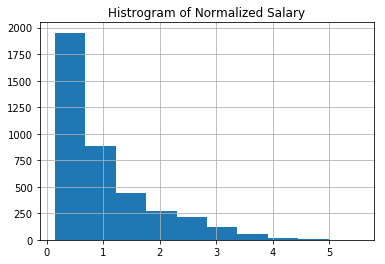

In [228]:
salaryMinAvg['normalizedSalary'].hist()
plt.title("Histrogram of Normalized Salary")

1. Salary divided by average yearly salary
2. WS / $M

In [229]:
salaryMinAvg['WS per $M'] = salaryMinAvg['WS'] / salaryMinAvg['normalizedSalary']

In [230]:
salaryMinAvg['WS per $M'].describe()

count    3956.000000
mean        4.357505
std         5.245628
min        -5.455439
25%         1.116542
50%         2.909609
75%         5.616076
max        52.301574
Name: WS per $M, dtype: float64

Text(0.5,1,'Histrogram of Win Share per Million Dollars Salary Normalized')

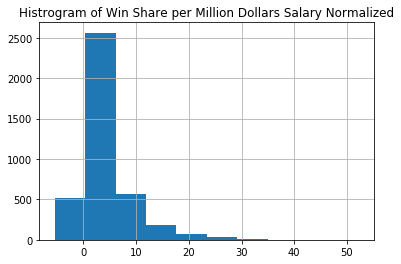

In [231]:
salaryMinAvg['WS per $M'].hist()
plt.title("Histrogram of Win Share per Million Dollars Salary Normalized")

In [232]:
salaryMinAvg.sort_values(['WS per $M'])[['Year','Player','WS','salary','WS per $M','normalizedSalary']].tail()

,Year,Player,WS,salary,WS per $M,normalizedSalary
131,2005,tayshaun prince,9.4,1038960,44.765402,0.209984
3032,2015,rudy gobert,9.3,1127400,46.378944,0.200522
3713,2017,rudy gobert,14.3,2121288,49.378634,0.289599
663,2007,kevin martin,10.2,1002840,51.824611,0.196818
3679,2017,nikola jokic,9.7,1358500,52.301574,0.185463


#### Filtering for minimum number of Games
* Group by year and summarize the average games 
* Decision to only include players who play 40 or more games

In [233]:
totalGamesPerPlayer = salaryMinAvg.groupby(['Year','Player']).sum()['G'].reset_index()

count    3951.000000
mean       57.274361
std        22.352020
min         1.000000
25%        41.000000
50%        64.000000
75%        76.000000
max        83.000000
Name: G, dtype: float64

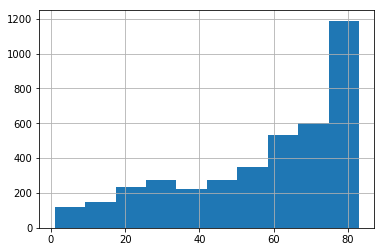

In [234]:
totalGamesPerPlayer['G'].hist()
totalGamesPerPlayer['G'].describe()

In [235]:
salaryMinAvgThreshold = salaryMinAvg.query('G >= 25')
print("Count of Records Before: ", len(salaryMinAvg))
print("Count of Records After Game Threshold: ", len(salaryMinAvgThreshold))

Count of Records Before:  3956
Count of Records After Game Threshold:  3484


--- 
## Analysis Against Transactions

#### A. Signed
* Identify all signed players
* Format signed player data to be appropriate for join
* Get start and end date of player tenure with team
* Calculate sum of normalized salary and sum of win shares

In [467]:
signedOnly = final.query('signed == True')

**Format player to lower**

**Format Data Types Appropriately**

In [468]:
signedOnly['player'] = signedOnly['acquiredkeep_'].map(lambda x: x.lower())
signedOnly['year'] = signedOnly['date'].map(lambda x: x[:4])
signedOnly['team'] = signedOnly['team'].map(lambda x: x.strip())
signedOnly['player'] = signedOnly['player'].map(lambda x: x.strip())

---

#### Test min / max methodology on Lebron James Data where he returns back to the Cavs

* Identify when the player and team are not the same on subsequent rows
* Generates an ID which increments each time there is a change

Utilize a group by function to identify the start and end dates with each stint

#### Apply methodology to entire dataframe

In [469]:
salaryMinAvgThresholdT = salaryMinAvgThreshold.sort_values(['Player','team'])
salaryMinAvgThresholdT['id'] = ((salaryMinAvgThresholdT.Tm != salaryMinAvgThresholdT.Tm.shift()) & (salaryMinAvgThresholdT.Player != salaryMinAvgThresholdT.Player.shift())).cumsum()
updatedNewM = salaryMinAvgThresholdT.groupby(['Player','team','id'])['Year'].min().reset_index()
updatedNewM = updatedNewM.rename(index=str,columns={"Year":"start"})
updatedNewE = salaryMinAvgThresholdT.groupby(['Player','team','id'])['Year'].max().reset_index()
updatedNewE = updatedNewE.rename(index=str,columns={"Year":"end"})

In [470]:
updatedNewV2t = pd.merge(salaryMinAvgThresholdT,updatedNewM,left_on=['team','Player','id'], right_on=['team','Player','id'])
tenureStats = pd.merge(updatedNewV2t,updatedNewE,left_on=['team','Player','id'], right_on=['team','Player','id'])

In [471]:
tenureStats.head()

,Player,Year,Tm,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,tm_stats,tm_salary,tm_transactions,player,salary,season_end,season_start,team,team_name,WS per $M,avgSalary,normalizedSalary,id,start,end
0,aaron brooks,2016,CHI,PG,31.0,69.0,0.0,1108.0,11.8,0.494,0.394,0.136,2.0,7.5,4.8,26.0,1.4,0.7,14.2,22.9,0.2,0.7,0.9,0.040,-0.5,-2.8,-3.3,-0.4,188.0,469.0,0.401,66.0,185.0,0.357,122.0,284.0,0.430,0.471,49.0,64.0,0.766,21.0,80.0,101.0,180.0,30.0,10.0,82.0,132.0,491.0,CHI,CHI,NaN,aaron brooks,2000000,2016,2015,CHI,Chicago Bulls,2.688029,5.973397e+06,0.334818,1,2016,2016
1,aaron brooks,2009,HOU,PG,24.0,80.0,35.0,1998.0,12.9,0.521,0.395,0.220,2.0,7.0,4.6,20.2,1.2,0.3,12.7,22.9,1.4,2.2,3.6,0.086,0.2,-1.5,-1.3,0.4,316.0,783.0,0.404,113.0,309.0,0.366,203.0,474.0,0.428,0.476,149.0,172.0,0.866,33.0,124.0,157.0,238.0,46.0,8.0,125.0,152.0,894.0,HOU,HOU,Rockets,aaron brooks,1045560,2009,2008,HOU,Houston Rockets,19.067086,5.537717e+06,0.188807,1,2009,2014
2,aaron brooks,2010,HOU,PG,25.0,82.0,82.0,2919.0,16.0,0.549,0.394,0.224,2.0,6.6,4.2,25.6,1.2,0.3,13.7,25.7,3.9,1.6,5.5,0.091,2.7,-2.5,0.2,1.6,575.0,1331.0,0.432,209.0,525.0,0.398,366.0,806.0,0.454,0.511,245.0,298.0,0.822,54.0,161.0,215.0,434.0,69.0,14.0,232.0,199.0,1604.0,HOU,HOU,Rockets,aaron brooks,1118520,2010,2009,HOU,Houston Rockets,26.267706,5.341992e+06,0.209383,1,2009,2014
3,aaron brooks,2014,HOU,PG,29.0,43.0,0.0,716.0,11.9,0.529,0.502,0.167,3.8,5.7,4.8,18.1,1.7,0.6,15.3,20.4,0.6,0.5,1.1,0.076,0.3,-2.1,-1.8,0.0,104.0,263.0,0.395,54.0,132.0,0.409,50.0,131.0,0.382,0.498,37.0,44.0,0.841,23.0,39.0,62.0,83.0,25.0,6.0,51.0,76.0,299.0,HOU,HOU,Rockets,aaron brooks,1027424,2014,2013,HOU,Houston Rockets,5.893110,5.504293e+06,0.186659,1,2009,2014
4,aaron brooks,2017,IND,PG,32.0,65.0,0.0,894.0,9.5,0.507,0.427,0.133,2.3,6.3,4.3,20.7,1.4,0.9,17.2,19.2,-0.2,0.5,0.3,0.016,-2.1,-2.6,-4.6,-0.6,121.0,300.0,0.403,48.0,128.0,0.375,73.0,172.0,0.424,0.483,32.0,40.0,0.800,18.0,51.0,69.0,125.0,25.0,9.0,66.0,93.0,322.0,IND,IND,Pacers,aaron brooks,2700000,2017,2016,IND,Indiana Pacers,0.813880,7.324916e+06,0.368605,1,2017,2017


---
### Join to transactions by GM

In [472]:
tenureStats['Year'] = tenureStats['Year'].astype(str)

In [473]:
ttl = pd.merge(tenureStats,signedOnly,left_on=['Player','Year','tm_transactions'],right_on=['player','year','team'])

In [474]:
len(ttl)

586

In [482]:
ttlTenures = ttl.loc[:,['Player','Tm','GM','start','end']].drop_duplicates()

In [483]:
fullDF = pd.merge(tenureStats,ttlTenures,left_on=['Player'],right_on=['Player'])

In [487]:
fullDF['start_x'] = fullDF['start_x'].map(lambda x: int(x))
fullDF['end_y'] = fullDF['end_y'].map(lambda x: int(x))
fullDF['Year'] = fullDF['Year'].map(lambda x: int(x))

In [498]:
fullDFv2 = fullDF.loc[(fullDF['Year']>=fullDF['start_y']) & (fullDF['Year']<= fullDF['end_y']) & (fullDF['Tm_y']==fullDF['team']),]

In [499]:
fullDFv2.head()

,Player,Year,Tm_x,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,tm_stats,tm_salary,tm_transactions,player,salary,season_end,season_start,team,team_name,WS per $M,avgSalary,normalizedSalary,id,start_x,end_x,Tm_y,GM,start_y,end_y
1,aaron brooks,2009,HOU,PG,24.0,80.0,35.0,1998.0,12.9,0.521,0.395,0.220,2.0,7.0,4.6,20.2,1.2,0.3,12.7,22.9,1.4,2.2,3.6,0.086,0.2,-1.5,-1.3,0.4,316.0,783.0,0.404,113.0,309.0,0.366,203.0,474.0,0.428,0.476,149.0,172.0,0.866,33.0,124.0,157.0,238.0,46.0,8.0,125.0,152.0,894.0,HOU,HOU,Rockets,aaron brooks,1045560,2009,2008,HOU,Houston Rockets,19.067086,5.537717e+06,0.188807,1,2009,2014,HOU,Daryl Morey,2009,2014
2,aaron brooks,2010,HOU,PG,25.0,82.0,82.0,2919.0,16.0,0.549,0.394,0.224,2.0,6.6,4.2,25.6,1.2,0.3,13.7,25.7,3.9,1.6,5.5,0.091,2.7,-2.5,0.2,1.6,575.0,1331.0,0.432,209.0,525.0,0.398,366.0,806.0,0.454,0.511,245.0,298.0,0.822,54.0,161.0,215.0,434.0,69.0,14.0,232.0,199.0,1604.0,HOU,HOU,Rockets,aaron brooks,1118520,2010,2009,HOU,Houston Rockets,26.267706,5.341992e+06,0.209383,1,2009,2014,HOU,Daryl Morey,2009,2014
3,aaron brooks,2014,HOU,PG,29.0,43.0,0.0,716.0,11.9,0.529,0.502,0.167,3.8,5.7,4.8,18.1,1.7,0.6,15.3,20.4,0.6,0.5,1.1,0.076,0.3,-2.1,-1.8,0.0,104.0,263.0,0.395,54.0,132.0,0.409,50.0,131.0,0.382,0.498,37.0,44.0,0.841,23.0,39.0,62.0,83.0,25.0,6.0,51.0,76.0,299.0,HOU,HOU,Rockets,aaron brooks,1027424,2014,2013,HOU,Houston Rockets,5.893110,5.504293e+06,0.186659,1,2009,2014,HOU,Daryl Morey,2009,2014
7,aaron gray,2012,TOR,C,27.0,49.0,40.0,813.0,11.1,0.526,0.000,0.292,12.1,28.3,20.3,5.5,1.5,1.7,21.9,13.5,0.1,1.3,1.4,0.082,-3.5,1.5,-2.0,0.0,83.0,161.0,0.516,0.0,0.0,NaN,83.0,161.0,0.516,0.516,25.0,47.0,0.532,83.0,198.0,281.0,27.0,22.0,17.0,51.0,127.0,191.0,TOR,TOR,Raptors,aaron gray,2500000,2012,2011,TOR,Toronto Raptors,2.904526,5.186654e+06,0.482006,3,2012,2013,TOR,Bryan Colangelo,2012,2013
8,aaron gray,2013,TOR,C,28.0,42.0,16.0,513.0,9.0,0.544,0.000,0.489,10.9,20.0,15.4,9.9,0.7,0.8,24.8,13.1,0.2,0.4,0.5,0.050,-3.0,0.1,-2.9,-0.1,48.0,90.0,0.533,0.0,0.0,NaN,48.0,90.0,0.533,0.533,23.0,44.0,0.523,48.0,85.0,133.0,33.0,7.0,5.0,36.0,85.0,119.0,TOR,TOR,Raptors,aaron gray,2575000,2013,2012,TOR,Toronto Raptors,1.025915,5.283461e+06,0.487370,3,2012,2013,TOR,Bryan Colangelo,2012,2013


In [502]:
fullDFv2Grp = fullDFv2.groupby(['GM','team']).sum().reset_index()

In [501]:
fullDFv2.to_csv('aggregated_signings.csv',sep=',')

In [505]:
fullDFv2Grp['WS per Normalized Salary'] = fullDFv2Grp['WS'] / fullDFv2Grp['normalizedSalary']

In [511]:
fullDFv2Grp.loc[:,['GM','team','WS per Normalized Salary']].set_index(['GM','team']).sort_values('WS per Normalized Salary',ascending=False).head()

,,WS per Normalized Salary
GM,team,
Bryan Colangelo,PHO,15.940707
Chad Buchanan,IND,15.183134
Dell Demps,NOH,7.766448
Rich Cho,NOH,7.766448
Scott Layden,MIN,7.606185


In [514]:
fullDFv2.head()

,Player,Year,Tm_x,Pos,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,tm_stats,tm_salary,tm_transactions,player,salary,season_end,season_start,team,team_name,WS per $M,avgSalary,normalizedSalary,id,start_x,end_x,Tm_y,GM,start_y,end_y
1,aaron brooks,2009,HOU,PG,24.0,80.0,35.0,1998.0,12.9,0.521,0.395,0.220,2.0,7.0,4.6,20.2,1.2,0.3,12.7,22.9,1.4,2.2,3.6,0.086,0.2,-1.5,-1.3,0.4,316.0,783.0,0.404,113.0,309.0,0.366,203.0,474.0,0.428,0.476,149.0,172.0,0.866,33.0,124.0,157.0,238.0,46.0,8.0,125.0,152.0,894.0,HOU,HOU,Rockets,aaron brooks,1045560,2009,2008,HOU,Houston Rockets,19.067086,5.537717e+06,0.188807,1,2009,2014,HOU,Daryl Morey,2009,2014
2,aaron brooks,2010,HOU,PG,25.0,82.0,82.0,2919.0,16.0,0.549,0.394,0.224,2.0,6.6,4.2,25.6,1.2,0.3,13.7,25.7,3.9,1.6,5.5,0.091,2.7,-2.5,0.2,1.6,575.0,1331.0,0.432,209.0,525.0,0.398,366.0,806.0,0.454,0.511,245.0,298.0,0.822,54.0,161.0,215.0,434.0,69.0,14.0,232.0,199.0,1604.0,HOU,HOU,Rockets,aaron brooks,1118520,2010,2009,HOU,Houston Rockets,26.267706,5.341992e+06,0.209383,1,2009,2014,HOU,Daryl Morey,2009,2014
3,aaron brooks,2014,HOU,PG,29.0,43.0,0.0,716.0,11.9,0.529,0.502,0.167,3.8,5.7,4.8,18.1,1.7,0.6,15.3,20.4,0.6,0.5,1.1,0.076,0.3,-2.1,-1.8,0.0,104.0,263.0,0.395,54.0,132.0,0.409,50.0,131.0,0.382,0.498,37.0,44.0,0.841,23.0,39.0,62.0,83.0,25.0,6.0,51.0,76.0,299.0,HOU,HOU,Rockets,aaron brooks,1027424,2014,2013,HOU,Houston Rockets,5.893110,5.504293e+06,0.186659,1,2009,2014,HOU,Daryl Morey,2009,2014
7,aaron gray,2012,TOR,C,27.0,49.0,40.0,813.0,11.1,0.526,0.000,0.292,12.1,28.3,20.3,5.5,1.5,1.7,21.9,13.5,0.1,1.3,1.4,0.082,-3.5,1.5,-2.0,0.0,83.0,161.0,0.516,0.0,0.0,NaN,83.0,161.0,0.516,0.516,25.0,47.0,0.532,83.0,198.0,281.0,27.0,22.0,17.0,51.0,127.0,191.0,TOR,TOR,Raptors,aaron gray,2500000,2012,2011,TOR,Toronto Raptors,2.904526,5.186654e+06,0.482006,3,2012,2013,TOR,Bryan Colangelo,2012,2013
8,aaron gray,2013,TOR,C,28.0,42.0,16.0,513.0,9.0,0.544,0.000,0.489,10.9,20.0,15.4,9.9,0.7,0.8,24.8,13.1,0.2,0.4,0.5,0.050,-3.0,0.1,-2.9,-0.1,48.0,90.0,0.533,0.0,0.0,NaN,48.0,90.0,0.533,0.533,23.0,44.0,0.523,48.0,85.0,133.0,33.0,7.0,5.0,36.0,85.0,119.0,TOR,TOR,Raptors,aaron gray,2575000,2013,2012,TOR,Toronto Raptors,1.025915,5.283461e+06,0.487370,3,2012,2013,TOR,Bryan Colangelo,2012,2013


In [516]:
fullDFv2.loc[(fullDFv2['GM']=="Chad Buchanan") & (fullDFv2['team']=="IND"),['Player','WS','normalizedSalary']]

,Player,WS,normalizedSalary
1561,myles turner,3.1,0.394710
1563,myles turner,8.0,0.336364


In [517]:
fullDFv2.loc[(fullDFv2['GM']=="Dell Demps") & (fullDFv2['team']=="NOH"),['Player','WS','normalizedSalary']]

,Player,WS,normalizedSalary
417,chris paul,10.4,0.637667
420,chris paul,8.8,0.663391
423,chris paul,17.8,0.683618
426,chris paul,18.3,0.826006
429,chris paul,7.3,2.530985
432,chris paul,13.9,2.753674
785,greivis vasquez,2.3,0.214705
787,greivis vasquez,3.8,0.225466
975,jason smith,1.6,0.403262
977,jason smith,2.2,0.482006


In [513]:
fullDFv2Grp.loc[:,['GM','team','WS per Normalized Salary']].set_index(['GM','team']).sort_values('WS per Normalized Salary',ascending=True).head()

,,WS per Normalized Salary
GM,team,
Steve Mills,NYK,1.930863
Elgin Baylor,LAC,2.406438
Bryan Colangelo,PHI,3.008212
Arturas Karnisovas,DEN,3.244589
Jon Horst,MIL,3.335664


In [518]:
fullDFv2.loc[(fullDFv2['GM']=="Steve Mills") & (fullDFv2['team']=="NYK"),['Player','WS','normalizedSalary']]

,Player,WS,normalizedSalary
82,andrea bargnani,1.5,2.155136
84,andrea bargnani,0.9,2.045417
318,carmelo anthony,3.2,3.160840
319,carmelo anthony,6.2,3.570428
320,carmelo anthony,9.5,3.681299
321,carmelo anthony,10.7,4.070908
322,carmelo anthony,2.9,3.994433
323,carmelo anthony,6.4,3.829479
324,carmelo anthony,4.7,3.352855
802,iman shumpert,2.4,0.301374


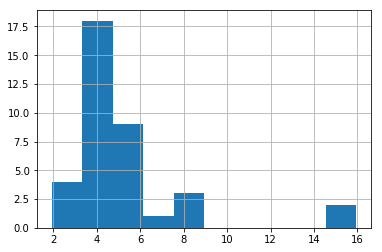

In [521]:
fullDFv2Grp['WS per Normalized Salary'].hist()

In [547]:
fullDFv2Grp['maxNorm'] = (fullDFv2Grp['WS per Normalized Salary'].max())
fullDFv2Grp['minNorm'] = fullDFv2Grp['WS per Normalized Salary'].min()

** Min/Max Scale the Normalized Values but Modify in Order to Make the Scale 0 - 0.5**

In [548]:
fullDFv2Grp['scaledSigningScore'] = (((0.5)*(fullDFv2Grp['WS per Normalized Salary'] - fullDFv2Grp['minNorm']))/(fullDFv2Grp['maxNorm'] - fullDFv2Grp['minNorm']))

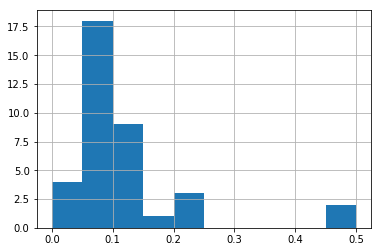

In [549]:
fullDFv2Grp['scaledSigningScore'].hist()

---
## Drafted
* Identify all the players that were drafted
* Join to the dataset
* Aggregate on draft pick number
* Calculate average WS per pick number
* Take the average WS and subtract it from actual average accrued win share
    * Large numbers mean outperforming
    * Small number mean underperforming

#### Read in the draft data

In [313]:
draftPicks = pd.read_csv('draftPicks.csv',sep=',')

In [315]:
draftPicks['avg WS'] = draftPicks['WS'] / draftPicks['yearsPro']

In [316]:
draftPicks.head()

,Year,Lg,Rd,Pk,Tm,Player,Age,Pos,Born,College,From,To,yearsPro,G,MP,PTS,TRB,AST,STL,BLK,FG%,2P%,3P%,FT%,WS,WS/48,avg WS
0,2017,NBA,1,1,PHI,Markelle Fultz,19.029,G,us,University of Washington,2018.0,2018.0,1,14.0,18.1,7.1,3.1,3.8,0.9,0.3,0.405,0.409,0.000,0.476,0.2,0.043,0.2
1,2017,NBA,1,2,LAL,Lonzo Ball,19.243,G,us,"University of California, Los Angeles",2018.0,2018.0,1,52.0,34.2,10.2,6.9,7.2,1.7,0.8,0.360,0.420,0.305,0.451,2.0,0.053,2.0
2,2017,NBA,1,3,BOS,Jayson Tatum,19.116,F,us,Duke University,2018.0,2018.0,1,80.0,30.5,13.9,5.0,1.6,1.0,0.7,0.475,0.492,0.434,0.826,7.1,0.139,7.1
3,2017,NBA,1,4,PHO,Josh Jackson,20.137,F-G,us,University of Kansas,2018.0,2018.0,1,77.0,25.4,13.1,4.6,1.5,1.0,0.5,0.417,0.464,0.263,0.634,-0.7,-0.018,-0.7
4,2017,NBA,1,5,SAC,De'Aaron Fox,19.189,G,us,University of Kentucky,2018.0,2018.0,1,73.0,27.8,11.6,2.8,4.4,1.0,0.3,0.412,0.436,0.307,0.723,-0.6,-0.014,-0.6


In [326]:
avgPick = draftPicks.groupby(['Pk']).median()['avg WS'].reset_index('Pk')

In [332]:
draftPicksTot = pd.merge(draftPicks,avgPick,left_on=['Pk'],right_on=['Pk'], suffixes = ("","_tot"))

In [333]:
draftPicksTot['diff'] = draftPicksTot['avg WS'] - draftPicksTot['avg WS_tot']

In [340]:
draftPicksTot[(draftPicksTot['WS'].isnull()==False)].sort_values('diff', ascending=False).head(10)

,Year,Lg,Rd,Pk,Tm,Player,Age,Pos,Born,College,From,To,yearsPro,G,MP,PTS,TRB,AST,STL,BLK,FG%,2P%,3P%,FT%,WS,WS/48,avg WS,avg WS_tot,diff
81,2005,NBA,1,4,NOH,Chris Paul,20.058,G,us,Wake Forest University,2006.0,2018.0,13,892.0,35.3,18.7,4.5,9.8,2.3,0.1,0.472,0.505,0.372,0.868,164.8,0.251,12.676923,3.357143,9.319780
14,2003,NBA,1,1,CLE,LeBron James,18.182,F-G,us,NaN,2004.0,2018.0,15,1143.0,38.8,27.2,7.4,7.2,1.6,0.8,0.504,0.547,0.344,0.739,219.4,0.238,14.626667,5.400000,9.226667
921,2014,NBA,2,41,DEN,Nikola Jokic,19.132,C-F,rs,NaN,2016.0,2018.0,3,228.0,27.3,14.9,9.1,4.4,1.0,0.7,0.530,0.572,0.366,0.832,27.1,0.209,9.033333,0.291667,8.741667
33,2007,NBA,1,2,SEA,Kevin Durant,18.276,F-G,us,University of Texas at Austin,2008.0,2018.0,11,771.0,37.1,27.1,7.1,3.9,1.2,1.1,0.490,0.527,0.384,0.882,130.2,0.219,11.836364,3.116667,8.719697
120,2012,NBA,1,6,POR,Damian Lillard,21.354,G,us,Weber State University,2013.0,2018.0,6,469.0,36.4,23.1,4.1,6.2,0.9,0.3,0.432,0.477,0.368,0.884,58.2,0.164,9.700000,2.166667,7.533333
146,2009,NBA,1,7,GSW,Stephen Curry,21.108,G,us,Davidson College,2010.0,2018.0,9,625.0,34.4,23.1,4.4,6.8,1.8,0.2,0.477,0.513,0.436,0.903,93.3,0.208,10.366667,2.985714,7.380952
1089,2007,NBA,2,48,LAL,Marc Gasol,22.155,C,es,NaN,2009.0,2018.0,10,716.0,33.7,15.2,7.7,3.3,0.9,1.5,0.487,0.499,0.344,0.779,73.5,0.146,7.350000,0.275000,7.075000
671,2011,NBA,1,30,CHI,Jimmy Butler,21.287,F-G,us,Marquette University,2012.0,2018.0,7,458.0,32.8,16.4,4.9,3.4,1.5,0.5,0.452,0.485,0.339,0.832,58.2,0.186,8.314286,1.250000,7.064286
54,2009,NBA,1,3,OKC,James Harden,19.308,G,us,Arizona State University,2010.0,2018.0,9,687.0,33.8,23.0,5.1,6.1,1.5,0.5,0.443,0.503,0.364,0.854,106.7,0.220,11.855556,4.853846,7.001709
789,2008,NBA,2,35,LAC,DeAndre Jordan,19.345,C,us,Texas A&M University,2009.0,2018.0,10,750.0,28.1,9.4,10.7,0.7,0.6,1.7,0.673,0.674,0.091,0.446,76.3,0.174,7.630000,0.690909,6.939091


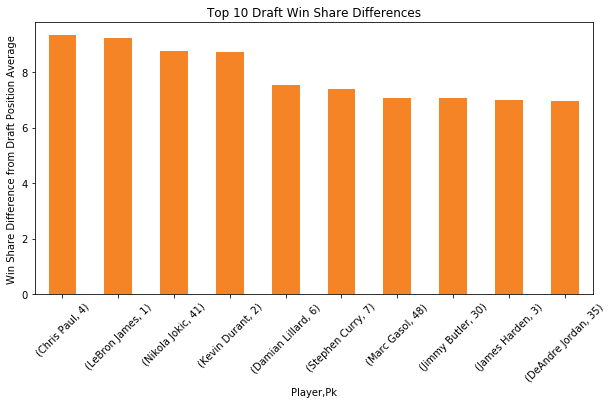

In [362]:
import seaborn as sns
sns.set_style()
draftPicksTot.loc[(draftPicksTot['WS'].isnull()==False),['Player','Pk','diff']].sort_values('diff', ascending=False)\
    .set_index(['Player','Pk']).head(10).plot(kind='bar',rot=45,figsize=[10,5],color="#F58426", legend=None)
plt.title('Top 10 Draft Win Share Differences')
plt.ylabel('Win Share Difference from Draft Position Average')
ax.set_ylim((0,15))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

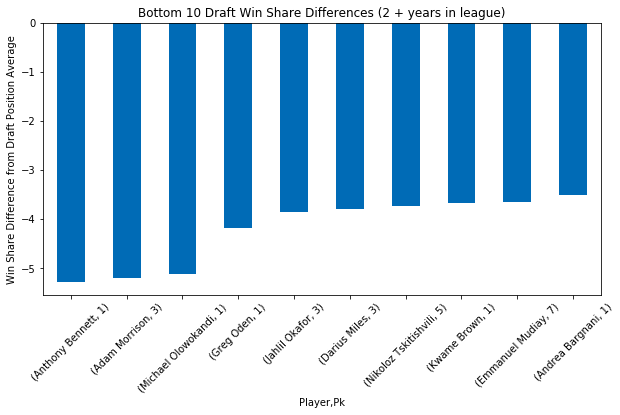

In [364]:
import seaborn as sns
sns.set_style()
draftPicksTot.loc[(draftPicksTot['WS'].isnull()==False)&(draftPicksTot['yearsPro'] >=2),['Player','Pk','diff']].sort_values('diff', ascending=True)\
    .set_index(['Player','Pk']).head(10).plot(kind='bar',rot=45,figsize=[10,5],color="#006BB6", legend=None)
plt.title('Bottom 10 Draft Win Share Differences (2 + years in league)')
plt.ylabel('Win Share Difference from Draft Position Average')
ax.set_ylim((-10,15))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


**Group GM Data to identify the tenure of each GM**

In [372]:
GMtenure = final.groupby(['GM','team']).agg({'date': ['min', 'max']}).reset_index()
GMtenure.columns = GMtenure.columns.get_level_values(1)
GMtenure.columns = ['GM','team','Start','End']
GMtenure.columns
GMtenure.head()

,GM,team,Start,End
0,Allan Bristow,Hornets,2004-06-22,2005-10-01
1,Arturas Karnisovas,Nuggets,2017-06-15,2018-02-08
2,Bob Myers,Warriors,2012-04-24,2018-04-10
3,Bryan Colangelo,76ers,2016-06-01,2018-03-26
4,Bryan Colangelo,Raptors,2006-02-28,2013-06-26


In [402]:
GMtenure['StartYr'] = GMtenure['Start'].map(lambda x: int(x[:4]))
GMtenure['EndYr'] = GMtenure['End'].map(lambda x: int(x[:4]))
GMtenure['team_nm'] = GMtenure['team'].map(lambda x: x.strip(" "))

**Join team name mapping to the picks data**

In [403]:
draftPicksTotMapped = pd.merge(draftPicksTot,teamLu,left_on=['Tm'], right_on=['tm_stats'])

In [404]:
draftPicksTotMapped.head()

,Year,Lg,Rd,Pk,Tm,Player,Age,Pos,Born,College,From,To,yearsPro,G,MP,PTS,TRB,AST,STL,BLK,FG%,2P%,3P%,FT%,WS,WS/48,avg WS,avg WS_tot,diff,tm_stats,tm_salary,tm_transactions
0,2017,NBA,1,1,PHI,Markelle Fultz,19.029,G,us,University of Washington,2018.0,2018.0,1,14.0,18.1,7.1,3.1,3.8,0.9,0.3,0.405,0.409,0.000,0.476,0.2,0.043,0.200000,5.400000,-5.200000,PHI,PHI,76ers
1,2016,NBA,1,1,PHI,Ben Simmons,19.343,G-F,au,Louisiana State University,2018.0,2018.0,1,81.0,33.7,15.8,8.1,8.2,1.7,0.9,0.545,0.551,0.000,0.560,9.2,0.162,9.200000,5.400000,3.800000,PHI,PHI,76ers
2,1996,NBA,1,1,PHI,Allen Iverson,21.025,G,us,Georgetown University,1997.0,2010.0,14,914.0,41.1,26.7,3.7,6.2,2.2,0.2,0.425,0.448,0.313,0.780,99.0,0.126,7.071429,5.400000,1.671429,PHI,PHI,76ers
3,2010,NBA,1,2,PHI,Evan Turner,21.245,G,us,Ohio State University,2011.0,2018.0,8,613.0,27.9,10.2,4.8,3.5,0.8,0.3,0.433,0.456,0.301,0.788,18.5,0.052,2.312500,3.116667,-0.804167,PHI,PHI,76ers
4,1997,NBA,1,2,PHI,Keith Van Horn,21.251,F,us,University of Utah,1998.0,2006.0,9,575.0,31.6,16.0,6.8,1.6,0.8,0.5,0.443,0.466,0.361,0.835,41.7,0.110,4.633333,3.116667,1.516667,PHI,PHI,76ers


In [405]:
GMten = pd.merge(draftPicksTotMapped,GMtenure, left_on=['tm_transactions'],right_on=['team_nm'],suffixes=("","_gm"))

In [406]:
GMten.head()

,Year,Lg,Rd,Pk,Tm,Player,Age,Pos,Born,College,From,To,yearsPro,G,MP,PTS,TRB,AST,STL,BLK,FG%,2P%,3P%,FT%,WS,WS/48,avg WS,avg WS_tot,diff,tm_stats,tm_salary,tm_transactions,GM,team,Start,End,StartYr,EndYr,team_nm
0,2017,NBA,1,1,PHI,Markelle Fultz,19.029,G,us,University of Washington,2018.0,2018.0,1,14.0,18.1,7.1,3.1,3.8,0.9,0.3,0.405,0.409,0.000,0.476,0.2,0.043,0.200000,5.4,-5.200000,PHI,PHI,76ers,Bryan Colangelo,76ers,2016-06-01,2018-03-26,2016,2018,76ers
1,2017,NBA,1,1,PHI,Markelle Fultz,19.029,G,us,University of Washington,2018.0,2018.0,1,14.0,18.1,7.1,3.1,3.8,0.9,0.3,0.405,0.409,0.000,0.476,0.2,0.043,0.200000,5.4,-5.200000,PHI,PHI,76ers,Tony DiLeo,76ers,2012-09-27,2013-05-11,2012,2013,76ers
2,2016,NBA,1,1,PHI,Ben Simmons,19.343,G-F,au,Louisiana State University,2018.0,2018.0,1,81.0,33.7,15.8,8.1,8.2,1.7,0.9,0.545,0.551,0.000,0.560,9.2,0.162,9.200000,5.4,3.800000,PHI,PHI,76ers,Bryan Colangelo,76ers,2016-06-01,2018-03-26,2016,2018,76ers
3,2016,NBA,1,1,PHI,Ben Simmons,19.343,G-F,au,Louisiana State University,2018.0,2018.0,1,81.0,33.7,15.8,8.1,8.2,1.7,0.9,0.545,0.551,0.000,0.560,9.2,0.162,9.200000,5.4,3.800000,PHI,PHI,76ers,Tony DiLeo,76ers,2012-09-27,2013-05-11,2012,2013,76ers
4,1996,NBA,1,1,PHI,Allen Iverson,21.025,G,us,Georgetown University,1997.0,2010.0,14,914.0,41.1,26.7,3.7,6.2,2.2,0.2,0.425,0.448,0.313,0.780,99.0,0.126,7.071429,5.4,1.671429,PHI,PHI,76ers,Bryan Colangelo,76ers,2016-06-01,2018-03-26,2016,2018,76ers


In [408]:
GMtenValid = GMten.loc[((GMten['StartYr']<=GMten['Year']) & (GMten['EndYr']>=GMten['Year'])),]

In [409]:
GMtenValid.to_csv('draftPicksTotal.csv',sep=',')

In [410]:
pd.set_option('display.max_columns', 500)
# signedTtl = ttl.groupby(['GM','Tm']).sum()
# df.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'})
draftTtl = GMtenValid.groupby(['GM','Tm']).agg({'diff':['sum','mean'], 'avg WS':['sum','mean']})
draftTtl

diff               avg WS          
                              sum      mean        sum      mean
GM                 Tm                                           
Allan Bristow      NOH  14.156685  4.718895  19.572161  6.524054
Arturas Karnisovas DEN   2.514286  1.257143   5.400000  2.700000
Bob Myers          GSW   6.346710  1.057785  13.908333  2.318056
Bryan Colangelo    PHI  -3.157116 -0.526186  10.700000  1.783333
                   PHO  18.854410  1.714037  35.836553  3.257868
                   TOR   9.841064  1.230133  29.216389  3.652049
Chad Buchanan      IND  -0.813333 -0.406667   0.900000  0.450000
Chris Wallace      MEM  -1.221429 -0.407143   1.100000  0.366667
Danny Ainge        BOS   3.796878  0.094922  50.594256  1.264856
Daryl Morey        HOU  21.284129  1.252008  39.228312  2.307548
Dave Babcock       MIL   9.596280  0.330906  45.516540  1.569536
Dave Wohl          LAC  -1.066667 -0.355556   1.283333  0.427778
Dell Demps         CHA   4.794286  1.598095  10.600000  3.533333
                   NOH   4.400000  0.733333  17.408333  2.901389
                   NOP  -2.423095 -0.484619   1.850000  0.370000
Dennis Lindsey     UTA   0.474589  0.031639  17.495000  1.166333
Elgin Baylor       LAC  -0.977132 -0.042484  45.353218  1.971879
Ernie Grunfeld     MIL   4.084304  0.453812  12.335657  1.370629
                   NYK  -4.541111 -0.756852   2.325556  0.387593
                   WAS   7.923735  0.344510  43.896275  1.908534
Jeff Bower         DET  -0.230357 -0.038393   5.658333  0.943056
John Hammond       MIL   7.114733  0.296447  34.525794  1.438575
Jon Horst          MIL  -0.046429 -0.023214   1.100000  0.550000
Kevin Pritchard    IND   3.342495  0.417812  11.623333  1.452917
Lance Blanks       PHO  -5.161558 -1.032312   5.487143  1.097429
Larry  Bird        IND  20.760857  1.384057  35.672183  2.378146
Lon Babby          PHO  -3.627273 -0.362727  15.187143  1.518714
Masai Ujiri        TOR   2.386364  0.477273  11.666667  2.333333
Michael Blackstone CLE  -3.219405 -0.229957  27.469048  1.962075
Mike Budenholzer   ATL   1.852619  0.370524   7.616667  1.523333
Neil Olshey        LAC   1.105714  0.221143   4.400000  0.880000
                   POR   8.777408  0.877741  22.850000  2.285000
Pat Riley          MIA  11.215660  0.400559  41.449459  1.480338
Pete Babcock       ATL   2.121469  0.111656  24.898638  1.310455
                   TOR  -5.823745 -0.831964   7.194545  1.027792
R.C. Buford        SAS  29.164668  1.458233  41.486908  2.074345
Rich Cho           NOH   4.666667  0.933333  16.208333  3.241667
                   NOP  -2.423095 -0.484619   1.850000  0.370000
Ryan McDonough     PHO -11.500487 -0.821463  12.680000  0.905714
Sam Presti         SEA  24.121923  3.445989  33.682475  4.811782
Scott Layden       MIN  -2.512987 -1.256494   3.800000  1.900000
Sean Marks         BRK   6.016667  2.005556   8.000000  2.666667
Steve Mills        NYK  -1.797143 -0.299524   6.073333  1.012222
Tony DiLeo         PHI  -0.822381 -0.137063   4.238333  0.706389
Travis Schlenk     ATL   3.638333  1.819167   5.800000  2.900000

In [412]:
draftTtl.columns = draftTtl.columns.get_level_values(1)
draftTtl.columns = ['diffSum','diffAvg','avgWSsum','avgWSavg']
draftTtl.columns
draftTtl.head()

diffSum   diffAvg   avgWSsum  avgWSavg
GM                 Tm                                           
Allan Bristow      NOH  14.156685  4.718895  19.572161  6.524054
Arturas Karnisovas DEN   2.514286  1.257143   5.400000  2.700000
Bob Myers          GSW   6.346710  1.057785  13.908333  2.318056
Bryan Colangelo    PHI  -3.157116 -0.526186  10.700000  1.783333
                   PHO  18.854410  1.714037  35.836553  3.257868

**Summed Differences**

C:\Anaconda2\envs\py36\lib\site-packages\pandas\core\indexing.py:972: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


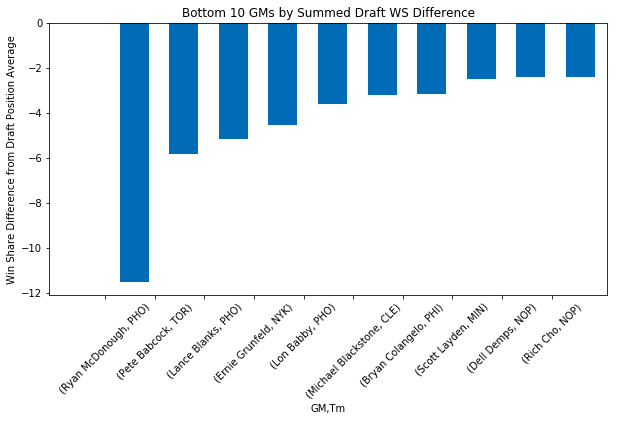

In [435]:
import seaborn as sns
sns.set_style()
draftTtl.loc[:,['GM','Tm','diffSum']].sort_values('diffSum', ascending=True).head(10).plot(kind='bar',rot=45,figsize=[10,5],color="#006BB6", legend=None,width=1.75)
plt.title('Bottom 10 GMs by Summed Draft WS Difference')
plt.ylabel('Win Share Difference from Draft Position Average')
# ax.set_ylim((-50,50))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

C:\Anaconda2\envs\py36\lib\site-packages\pandas\core\indexing.py:972: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


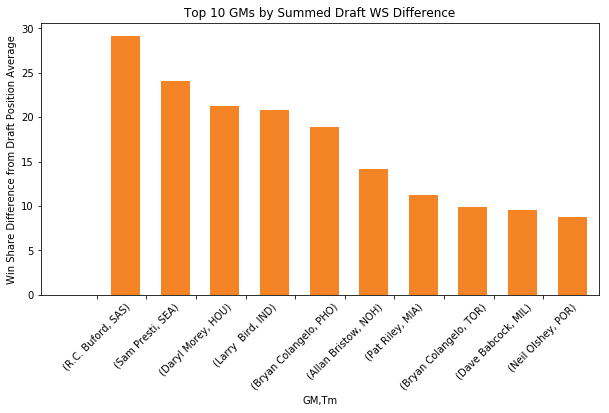

In [436]:
import seaborn as sns
sns.set_style()
draftTtl.loc[:,['GM','Tm','diffSum']].sort_values('diffSum', ascending=False).head(10).plot(kind='bar',rot=45,figsize=[10,5],color="#F58426", legend=None,width=1.75)
plt.title('Top 10 GMs by Summed Draft WS Difference')
plt.ylabel('Win Share Difference from Draft Position Average')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

**Average Differences**

C:\Anaconda2\envs\py36\lib\site-packages\pandas\core\indexing.py:972: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


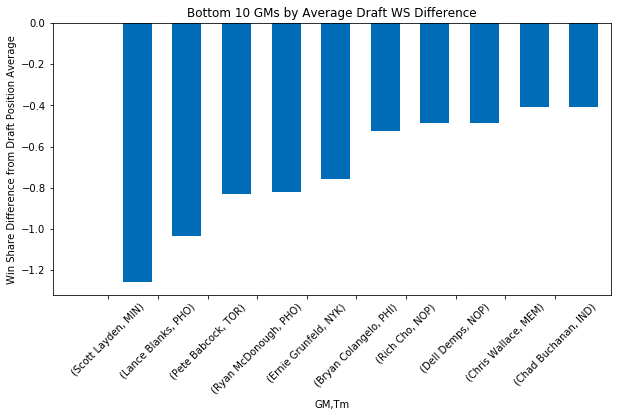

In [434]:
import seaborn as sns
sns.set_style()
draftTtl.loc[:,['GM','Tm','diffAvg']].sort_values('diffAvg', ascending=True).head(10).plot(kind='bar',rot=45,figsize=[10,5],color="#006BB6", legend=None,width=1.75)
plt.title('Bottom 10 GMs by Average Draft WS Difference')
plt.ylabel('Win Share Difference from Draft Position Average')
# ax.set_ylim((-50,50))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

C:\Anaconda2\envs\py36\lib\site-packages\pandas\core\indexing.py:972: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


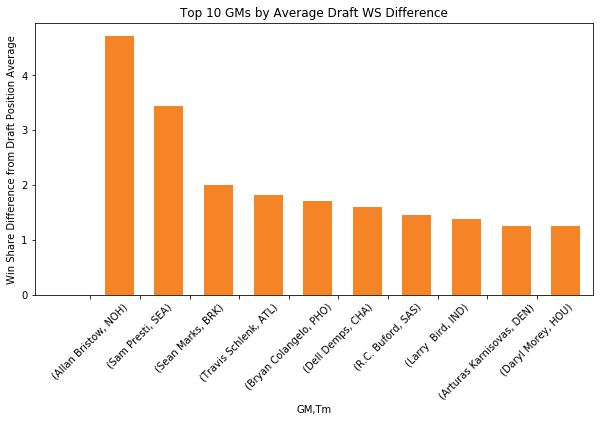

In [437]:
import seaborn as sns
sns.set_style()
draftTtl.loc[:,['GM','Tm','diffAvg']].sort_values('diffAvg', ascending=False).head(10).plot(kind='bar',rot=45,figsize=[10,5],color="#F58426", legend=None,width=1.75)
plt.title('Top 10 GMs by Average Draft WS Difference')
plt.ylabel('Win Share Difference from Draft Position Average')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

**Query For Some Specific Examples**

*Sam Presti*

In [445]:
GMtenValid.loc[(GMtenValid['GM']=="Sam Presti"),['Player','Pk','WS','avg WS','diff']].sort_values('diff',ascending=False).head()

,Player,Pk,WS,avg WS,diff
1809,Bogdan Bogdanovic,27,2.9,2.900,1.616667
1853,Andrew Harrison,44,3.3,1.650,1.020000
1761,T.J. Warren,14,10.9,2.725,0.791667
1821,Skal Labissiere,28,2.6,1.300,0.525000
1877,Alec Peters,54,0.3,0.300,0.100000


*Ryan McDonough*

In [447]:
GMtenValid.loc[(GMtenValid['GM']=="Ryan McDonough"),['Player','Pk','WS','avg WS','diff']].sort_values('diff',ascending=True).head()

,Player,Pk,WS,avg WS,diff
1721,Josh Jackson,4,-0.7,-0.700,-4.057143
1725,Dragan Bender,4,-0.3,-0.150,-3.507143
1745,Georgios Papagiannis,13,0.4,0.200,-2.685714
1829,Nemanja Nedovic,30,-0.4,-0.400,-1.650000
1781,Tyler Ennis,18,1.3,0.325,-1.108333


*R.C. Buford*

In [448]:
GMtenValid.loc[(GMtenValid['GM']=="R.C. Buford"),['Player','Pk','WS','avg WS','diff']].sort_values('diff',ascending=False).head()

,Player,Pk,WS,avg WS,diff
986,George Hill,26,57.1,5.710000,4.521932
1011,Luis Scola,56,45.7,4.570000,4.370000
1003,Goran Dragic,45,49.4,4.940000,4.215000
989,Tiago Splitter,28,25.3,3.614286,2.839286
996,Cory Joseph,29,18.3,2.614286,2.139286


*Daryl Morey*

In [450]:
GMtenValid.loc[(GMtenValid['GM']=="Daryl Morey"),['Player','Pk','WS','avg WS','diff']].sort_values('diff',ascending=False).head()

,Player,Pk,WS,avg WS,diff
918,Clint Capela,25,20.6,5.150000,4.200000
919,Nicolas Batum,25,50.4,5.040000,4.090000
927,Chandler Parsons,38,29.1,4.157143,3.807143
923,Montrezl Harrell,32,10.5,3.500000,3.337500
914,Nikola Mirotic,23,17.4,4.350000,2.316667


*Lance Blanks*

In [459]:
GMtenValid.loc[(GMtenValid['GM']=="Lance Blanks"),['Player','Pk','WS','avg WS','diff']].sort_values('diff',ascending=False).head()

,Player,Pk,WS,avg WS,diff
1755,Markieff Morris,13,22.1,3.157143,0.271429
1855,Gani Lawal,46,0.0,0.000000,-0.300000
1727,Alex Len,5,12.4,2.480000,-0.847273
1827,Nemanja Nedovic,30,-0.4,-0.400000,-1.650000
1751,Kendall Marshall,13,1.0,0.250000,-2.635714


**Create a Scaled Score**

In [543]:
draftTtl['diffMin'] = draftTtl['diffSum'].min()
draftTtl['diffMax'] = draftTtl['diffSum'].max()
draftTtl['scaledDraftScore'] = (((0.5)*(draftTtl['diffSum'] - draftTtl['diffMin']))/(draftTtl['diffMax'] - draftTtl['diffMin'])) 

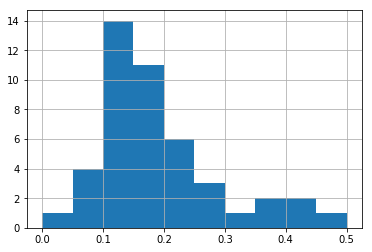

In [544]:
draftTtl['scaledDraftScore'].hist()

---
## Aggregate the Scores to Create One Composite Score

In [562]:
SignedEnd = fullDFv2Grp.loc[:,['GM','team','scaledSigningScore']]
SignedEnd.columns = ['GM','Team','signingScore']

In [563]:
DraftedEnd = draftTtl.loc[:,['scaledDraftScore']].reset_index()
DraftedEnd.columns = ['GM','Team','draftedScore']

In [564]:
DraftedEnd.head()

,GM,Team,draftedScore
0,Allan Bristow,NOH,0.315469
1,Arturas Karnisovas,DEN,0.172319
2,Bob Myers,GSW,0.219441
3,Bryan Colangelo,PHI,0.102586
4,Bryan Colangelo,PHO,0.373230


In [565]:
compositeEnd = pd.merge(SignedEnd,DraftedEnd,)

In [566]:
compositeEnd.head()

,GM,Team,signingScore,draftedScore
0,Allan Bristow,NOH,0.131436,0.315469
1,Arturas Karnisovas,DEN,0.046886,0.172319
2,Bob Myers,GSW,0.092262,0.219441
3,Bryan Colangelo,PHI,0.038450,0.102586
4,Bryan Colangelo,PHO,0.500000,0.373230


In [568]:
compositeEnd['totalScore'] = compositeEnd['signingScore'] + compositeEnd['draftedScore']

Text(0.5,1,'Distribution of Total GM Score')

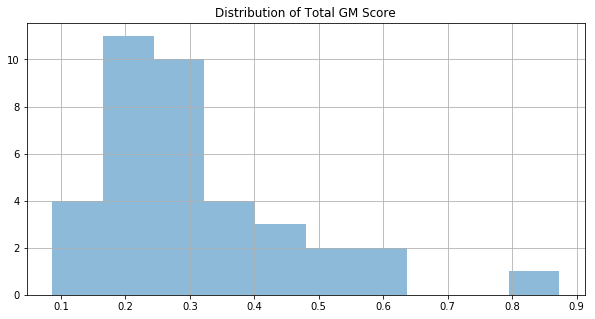

In [575]:
compositeEnd['totalScore'].hist(alpha = 0.5,figsize=[10,5])
plt.title("Distribution of Total GM Score")

In [576]:
compositeEnd.sort_values('totalScore',ascending=False).head()

,GM,Team,signingScore,draftedScore,totalScore
4,Bryan Colangelo,PHO,0.500000,0.373230,0.873230
6,Chad Buchanan,IND,0.472963,0.131404,0.604367
30,R.C. Buford,SAS,0.087172,0.500000,0.587172
9,Daryl Morey,HOU,0.148486,0.403105,0.551590
21,Larry Bird,IND,0.103658,0.396671,0.500328


In [578]:
compositeEnd.sort_values('totalScore',ascending=True).head()

,GM,Team,signingScore,draftedScore,totalScore
32,Ryan McDonough,PHO,0.086493,0.000000,0.086493
34,Steve Mills,NYK,0.000000,0.119308,0.119308
3,Bryan Colangelo,PHI,0.038450,0.102586,0.141036
14,Elgin Baylor,LAC,0.016973,0.129390,0.146363
20,Lance Blanks,PHO,0.103278,0.077941,0.181218


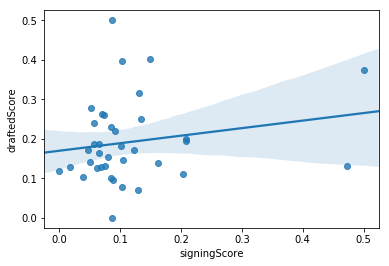

In [594]:
sns.regplot(x=compositeEnd["signingScore"], y=compositeEnd["draftedScore"])

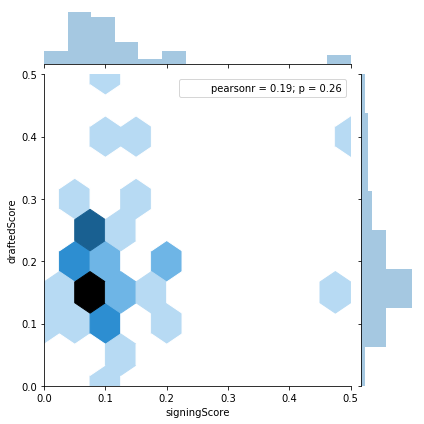

In [595]:
sns.jointplot(x=compositeEnd["signingScore"], y=compositeEnd["draftedScore"], kind='hex')

In [587]:
compositeEnd['signingScore']

0     0.131436
1     0.046886
2     0.092262
3     0.038450
4     0.500000
5     0.069603
6     0.472963
7     0.061949
8     0.057686
9     0.148486
10    0.073883
11    0.068904
12    0.208267
13    0.104687
14    0.016973
15    0.057689
16    0.162726
17    0.085069
18    0.050136
19    0.101230
20    0.103278
21    0.103658
22    0.088074
23    0.122228
24    0.084112
25    0.065825
26    0.080533
27    0.133459
28    0.051201
29    0.128462
30    0.087172
31    0.208267
32    0.086493
33    0.202548
34    0.000000
35    0.074679
36    0.064358
Name: signingScore, dtype: float64

In [597]:
compositeEnd.head()

,GM,Team,signingScore,draftedScore,totalScore
0,Allan Bristow,NOH,0.131436,0.315469,0.446905
1,Arturas Karnisovas,DEN,0.046886,0.172319,0.219205
2,Bob Myers,GSW,0.092262,0.219441,0.311703
3,Bryan Colangelo,PHI,0.038450,0.102586,0.141036
4,Bryan Colangelo,PHO,0.500000,0.373230,0.873230


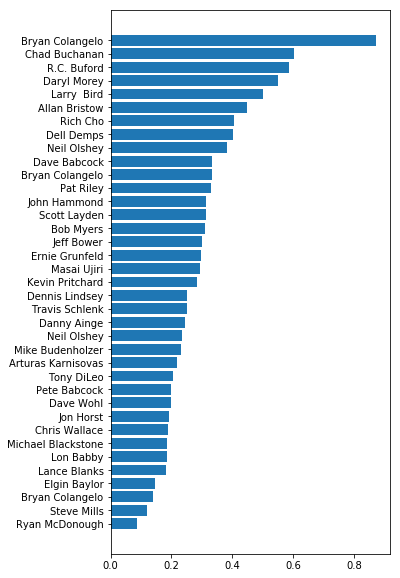

In [609]:
compositeEnd = compositeEnd.sort_values('totalScore')    

# Make fake dataset
height = compositeEnd['totalScore']
bars = compositeEnd['GM']
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
 
# Show graphic
plt.rcParams["figure.figsize"] = [5,10]

plt.show()